## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import NMF

from pprint import pprint

In [2]:
from tqdm.auto import tqdm
from collections import Counter
from wordcloud import WordCloud, STOPWORDS

tqdm.pandas()

In [3]:
nlp = spacy.load('en_core_web_sm')

## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [4]:
# Opening JSON file 
file = '../data/complaints.json'# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
with open(file) as f:
    data = json.load(f)
df = pd.json_normalize(data)

## Data preparation

In [5]:
# Inspect the dataframe to understand the given data.

df.head()

,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,...,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [6]:
# print the column names
df.columns

Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [7]:
# Assign new column names
rename_mapping = {x: x[1:].replace('source.', '').replace('_what_happened', '') for x in df.columns}
df = df.rename(columns=rename_mapping)
df.head()

,index,type,id,score,tags,zip_code,complaint_id,issue,date_received,state,...,company_response,company,submitted_via,date_sent_to_company,company_public_response,sub_product,timely,complaint,sub_issue,consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,...,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,...,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [8]:
# Assign nan in place of blanks in the complaints column
df['complaint'] = df['complaint'].apply(lambda x: np.nan if x == '' else x)
df['complaint'].isna().sum()

57241

In [9]:
df.shape

(78313, 22)

In [10]:
# Remove all rows where complaints column is nan
df = df.dropna(subset=['complaint'])
df.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Use POS tags to get relevant words from the texts.


In [11]:
# Write your function here to clean the text and remove all the unnecessary elements.
def preprocess_text(text):
    text = text.lower()
    output = []
    for word in text.split():
        if (word[0] == '[' and word[-1] == ']'):
            continue
        if re.search("[0-9]", word):
            continue
        output.append(word)
    text = " ".join(output)
    text = re.sub("[^a-z0-9 ]", "", text)
    return text

In [12]:
text = "Test, Text 1234 test12 [Test] [Test @test"
assert preprocess_text(text) == 'test text test test'

In [13]:
# Write your function to Lemmatize the texts
def lemmatize_text(text):
    text = preprocess_text(text)
    doc = nlp(text)
    output = []
    for token in doc:
        output.append(token.lemma_)
    return " ".join(output)

In [14]:
# text = "Apples and oranges are similar. John ate the apples."
# lemmatize_text(text)

In [15]:
# Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = df[['complaint']].copy()
df_clean['complaint_lemma'] = df_clean['complaint'].progress_apply(lemmatize_text)

  0%|          | 0/21072 [00:00<?, ?it/s]

In [16]:
df_clean

,complaint,complaint_lemma
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell by ...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket I come...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...
...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I ve have ...


In [17]:
# Write your function to extract the POS tags 
def clean_pos(text):
    doc = nlp(text)
    output = []
    for token in doc:
        if token.pos_ == 'NOUN':
            output.append(token.text)
    return " ".join(output)

In [18]:
# doc = nlp('My name is Paresh Pradhan.')
# [(token.text, token.pos_) for token in doc]

In [19]:
df_clean['complaint_POS_removed'] = df_clean['complaint_lemma'].progress_apply(clean_pos)

  0%|          | 0/21072 [00:00<?, ?it/s]

In [20]:
# The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean

,complaint,complaint_lemma,complaint_POS_removed
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop bank cardmember service...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell by ...,card agent anniversary date agent information ...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,card report application identity consent servi...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket I come...,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...
...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...,credit card provider claim purchase protection...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk consumer chase bank app chase year ba...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I ve have ...,credit yrs chase credit card freedom xxxx prob...


## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




<AxesSubplot:ylabel='Frequency'>

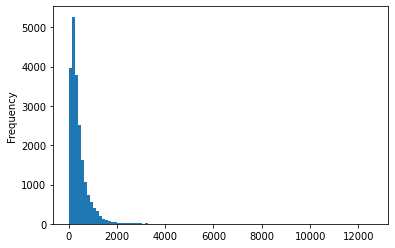

In [21]:
# Write your code here to visualise the data according to the 'Complaint' character length
df_clean['complaint_POS_removed'].apply(len).plot.hist(bins=100)

#### Find the top 40 words by frequency among all the articles after processing the text.

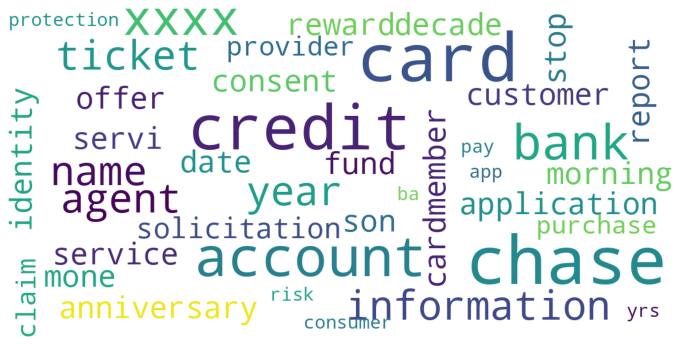

In [22]:
# Using a word cloud find the top 40 words by frequency among all the articles after processing the text
stopwords = set(STOPWORDS)

def show_wordcloud(data, max_words=40, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=40,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

show_wordcloud(df_clean['complaint_POS_removed'])

In [23]:
# Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [24]:
corpus = " ".join(df_clean['Complaint_clean'])

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [25]:
# Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_topn_ngrams(corpus, n_gram=1, top_n=30):
    n_grams = nltk.ngrams(corpus.split(), n_gram)
    n_grams = [' '.join(x) for x in n_grams]
    freq = Counter(n_grams)
    return sorted(freq.items(), key=lambda x: x[1], reverse=True)[:top_n]

In [26]:
# Print the top 10 words in the unigram frequency
get_topn_ngrams(corpus, n_gram=1, top_n=10)

[('xxxx', 84303),
 ('chase', 48221),
 ('account', 47336),
 ('credit', 33479),
 ('card', 29855),
 ('payment', 21118),
 ('bank', 17489),
 ('time', 16025),
 ('charge', 14177),
 ('day', 12935)]

In [27]:
# Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 
# done

In [28]:
# Print the top 10 words in the bigram frequency
get_topn_ngrams(corpus, n_gram=2, top_n=10)

[('xxxx xxxx', 21664),
 ('credit card', 12834),
 ('credit report', 3966),
 ('customer service', 3081),
 ('chase credit', 2896),
 ('account chase', 2674),
 ('xxxx chase', 2621),
 ('checking account', 2604),
 ('account xxxx', 2579),
 ('chase account', 2440)]

In [29]:
# Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
# done

In [30]:
# Print the top 10 words in the trigram frequency
get_topn_ngrams(corpus, n_gram=3, top_n=10)

[('xxxx xxxx xxxx', 5228),
 ('chase credit card', 2023),
 ('credit card account', 1065),
 ('credit card company', 980),
 ('xxxx credit card', 706),
 ('xxxx xxxx chase', 675),
 ('account xxxx xxxx', 657),
 ('credit card chase', 594),
 ('credit card xxxx', 543),
 ('inquiry credit report', 500)]

## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [31]:
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [32]:
# All masked texts has been removed
df_clean

,complaint,complaint_lemma,complaint_POS_removed,Complaint_clean
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop bank cardmember service...,morning name stop bank cardmember service deb...
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell by ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket I come...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...
...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...,credit card provider claim purchase protection...,credit card provider claim purchase protection...
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I ve have ...,credit yrs chase credit card freedom xxxx prob...,credit yrs chase credit card freedom problem ...


## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [33]:
# Write your code here to initialise the TfidfVectorizer 
tfidf = TfidfVectorizer(
    stop_words='english', 
    ngram_range=(1, 3), 
    max_df=0.95, 
    min_df=2, 
    max_features=5000
)


#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [34]:
# Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
dtm = tfidf.fit_transform(df_clean['Complaint_clean'])

In [35]:
tfidf.get_feature_names_out()

array(['aarp', 'ability', 'abuse', ..., 'yr', 'zip', 'zip code'],
      dtype=object)

In [36]:
# tfidf.transform([df_clean['Complaint_clean'][1]])

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [37]:
# Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

# keep the random_state =40
nmf_model = NMF(n_components=num_topics, init='random', random_state=40) #write your code here

In [38]:
nmf_model.fit(dtm)
feature_names = tfidf.get_feature_names_out()
len(feature_names)

5000

In [39]:
# nmf_model.transform(tfidf.transform([df_clean['Complaint_clean'][1]])).argmax()

In [40]:
# Print the Top15 words for each of the topics
def plot_top_words(model, feature_names, n_top_words):
    fig, axes = plt.subplots(1, 5, figsize=(15, 4), sharex=True)
    axes = axes.flatten()
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[: -n_top_words - 1 : -1]
        top_features = [feature_names[i] for i in top_features_ind]
        weights = topic[top_features_ind]

        ax = axes[topic_idx]
        ax.barh(top_features, weights, height=0.7)
        ax.set_title(f"Topic {topic_idx}")
        ax.invert_yaxis()

    plt.subplots_adjust(top=0.90, bottom=0.05, wspace=1.5, hspace=0.5)
    plt.show()

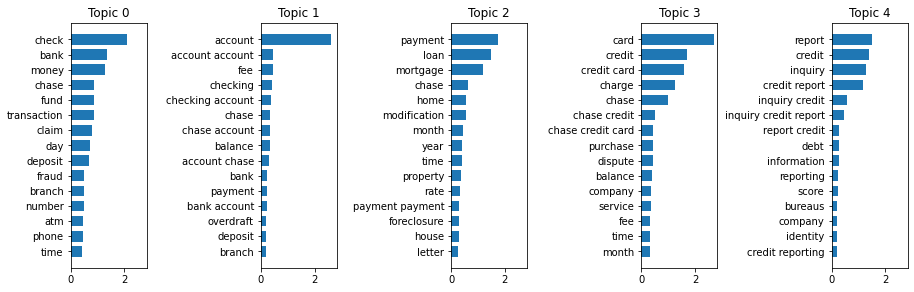

In [41]:
plot_top_words(nmf_model, feature_names, 15)

In [42]:
# Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
def get_topic(complaint, tfidf=tfidf, nmf_model=nmf_model):
    tfidf_vector = tfidf.transform([complaint])
    topic_id = nmf_model.transform(tfidf_vector).argmax()
    return topic_id

In [43]:
# Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = df_clean['Complaint_clean'].progress_apply(get_topic) #write your code to assign topics to each rows.

  0%|          | 0/21072 [00:00<?, ?it/s]

In [44]:
df_clean.head()

,complaint,complaint_lemma,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop bank cardmember service...,morning name stop bank cardmember service deb...,1
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell by ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,4
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket I come...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,4
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0


In [45]:
# Print the first 5 Complaint for each of the Topics
df_clean_grp = df_clean.groupby('Topic').head(5)
df_clean_grp.sort_values('Topic')

,complaint,complaint_lemma,complaint_POS_removed,Complaint_clean,Topic
69,Someone called stating I had felony committed ...,someone call state I have felony commit under ...,call state felony commit security number name ...,call state felony commit security number name ...,0
52,My roommate was stealing my Chase debit card a...,my roommate be steal my chase debit card and d...,roommate chase debit card driver license money...,roommate chase debit card driver license money...,0
48,"JP Morgan Chase Bank, please answer the follow...",jp morgan chase bank please answer the follow ...,follow question information xxxx reason access...,follow question information reason access inf...,0
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
21,"On XXXX XX/XX/2019, I made a {$300.00} payment...",on xxxx I make a payment to an online retailer...,xxxx payment retailer use pay xxxx chase websi...,payment retailer use pay chase website scam ...,0
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop bank cardmember service...,morning name stop bank cardmember service deb...,1
24,mishandling of this account by Chase auto and ...,mishandle of this account by chase auto and xxxx,mishandle account auto xxxx,mishandle account auto,1
27,I opened an account with chase bank on XXXX an...,I open an account with chase bank on xxxx and ...,account xxxx code bonus xxxxxxxx term account ...,account code bonus term account deposit bonu...,1
17,With out notice J.P. Morgan Chase restricted m...,with out notice jp morgan chase restrict my ac...,notice account debit card branch customer serv...,notice account debit card branch customer serv...,1
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell by ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
* Bank Account services
* Credit card or prepaid card
* Theft/Dispute Reporting
* Mortgage/Loan
* Others

In [46]:
# Create the dictionary of Topic names and Topics
Topic_names = {
    3: 'Credit card / Prepaid card',
    1: 'Bank account services',
    4: 'Others',
    0: 'Theft/Dispute reporting',
    2: 'Mortgages/loans',
}
# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [47]:
df_clean

,complaint,complaint_lemma,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop bank cardmember service...,morning name stop bank cardmember service deb...,Bank account services
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell by ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,Bank account services
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,Others
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket I come...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,Others
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,Theft/Dispute reporting
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,Credit card / Prepaid card
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...,credit card provider claim purchase protection...,credit card provider claim purchase protection...,Theft/Dispute reporting
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...,Theft/Dispute reporting
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I ve have ...,credit yrs chase credit card freedom xxxx prob...,credit yrs chase credit card freedom problem ...,Credit card / Prepaid card


## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [48]:
# Create the dictionary again of Topic names and Topics

Topic_ids = {y: x for x, y in Topic_names.items()}
# Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_ids)

In [49]:
df_clean

,complaint,complaint_lemma,complaint_POS_removed,Complaint_clean,Topic
1,Good morning my name is XXXX XXXX and I apprec...,good morning my name be xxxx xxxx and I apprec...,morning name xxxx stop bank cardmember service...,morning name stop bank cardmember service deb...,1
2,I upgraded my XXXX XXXX card in XX/XX/2018 and...,I upgrade my xxxx xxxx card in and be tell by ...,card agent anniversary date agent information ...,card agent anniversary date agent information ...,1
10,Chase Card was reported on XX/XX/2019. However...,chase card be report on however fraudulent app...,card report application identity consent servi...,card report application identity consent servi...,4
11,"On XX/XX/2018, while trying to book a XXXX XX...",on while try to book a xxxx xxxx ticket I come...,ticket offer ticket reward card information of...,ticket offer ticket reward card information of...,4
14,my grand son give me check for {$1600.00} i de...,my grand son give I check for I deposit it int...,son chase account fund chase bank account mone...,son chase account fund chase bank account mone...,0
...,...,...,...,...,...
78303,After being a Chase Card customer for well ove...,after be a chase card customer for well over a...,chase card customer decade solicitation credit...,chase card customer decade solicitation credit...,3
78309,"On Wednesday, XX/XX/XXXX I called Chas, my XXX...",on wednesday xxxxxxxx I call chas my xxxx xxxx...,credit card provider claim purchase protection...,credit card provider claim purchase protection...,0
78310,I am not familiar with XXXX pay and did not un...,I be not familiar with xxxx pay and do not und...,pay risk consumer chase bank app chase year ba...,pay risk consumer chase bank app chase year ba...,0
78311,I have had flawless credit for 30 yrs. I've ha...,I have have flawless credit for yrs I ve have ...,credit yrs chase credit card freedom xxxx prob...,credit yrs chase credit card freedom problem ...,3


In [50]:
# Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[['Complaint_clean', 'Topic']].copy()

In [51]:
training_data

,Complaint_clean,Topic
1,morning name stop bank cardmember service deb...,1
2,card agent anniversary date agent information ...,1
10,card report application identity consent servi...,4
11,ticket offer ticket reward card information of...,4
14,son chase account fund chase bank account mone...,0
...,...,...
78303,chase card customer decade solicitation credit...,3
78309,credit card provider claim purchase protection...,0
78310,pay risk consumer chase bank app chase year ba...,0
78311,credit yrs chase credit card freedom problem ...,3


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [52]:
# Write your code to get the Vector count
count_vect = CountVectorizer(
    stop_words='english', 
    ngram_range=(1, 3), 
    max_df=0.95, 
    min_df=2, 
    max_features=5000
)

X_counts = count_vect.fit_transform(training_data['Complaint_clean'])
X_counts.shape

(21072, 5000)

In [53]:
# Write your code here to transform the word vector to tf-idf
tfidf_transformer = TfidfTransformer()

X_tfidf = tfidf_transformer.fit_transform(X_counts)
X_tfidf.shape

(21072, 5000)

In [54]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, training_data['Topic'], 
                                                    test_size = 0.3,
                                                    random_state = 0)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [55]:
# Write your code here to build any 3 models and evaluate them using the required metrics

In [56]:
# LogisticRegression
clf_lr = LogisticRegression(max_iter=400)
clf_lr.fit(X_train, y_train)
y_pred = clf_lr.predict(X_test)
precision_recall_fscore_support_score = precision_recall_fscore_support(y_test.values, y_pred)

In [57]:
model_name = 'lr'
df_lr = pd.DataFrame(
    precision_recall_fscore_support_score, 
    columns=[Topic_names[i] for i in range(5)],
    index=[f'precision_{model_name}', f'recall_{model_name}', f'f1_{model_name}', f'support_{model_name}']
)
# df_lr['Model'] = 'LogisticRegression'

In [58]:
# DecisionTreeClassifier
clf_dtree = DecisionTreeClassifier()
clf_dtree.fit(X_train, y_train)
y_pred = clf_dtree.predict(X_test)
precision_recall_fscore_support_score = precision_recall_fscore_support(y_test.values, y_pred)

In [59]:
model_name = 'dtree'
df_dtree = pd.DataFrame(
    precision_recall_fscore_support_score, 
    columns=[Topic_names[i] for i in range(5)],
    index=[f'precision_{model_name}', f'recall_{model_name}', f'f1_{model_name}', f'support_{model_name}']
)
# df_dtree['Model'] = 'DecisionTreeClassifier'

In [60]:
# RandomForestClassifier
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train, y_train)
y_pred = clf_rf.predict(X_test)
precision_recall_fscore_support_score = precision_recall_fscore_support(y_test.values, y_pred)

In [61]:
model_name = 'rf'
df_rf = pd.DataFrame(
    precision_recall_fscore_support_score, 
    columns=[Topic_names[i] for i in range(5)],
    index=[f'precision_{model_name}', f'recall_{model_name}', f'f1_{model_name}', f'support_{model_name}']
)
# df_rf['Model'] = 'RandomForestClassifier'

In [62]:
# MultinomialNB
clf_nb = MultinomialNB()
clf_nb.fit(X_train, y_train)
y_pred = clf_nb.predict(X_test)
precision_recall_fscore_support_score = precision_recall_fscore_support(y_test.values, y_pred)

In [63]:
model_name = 'nb'
df_nb = pd.DataFrame(
    precision_recall_fscore_support_score, 
    columns=[Topic_names[i] for i in range(5)],
    index=[f'precision_{model_name}', f'recall_{model_name}', f'f1_{model_name}', f'support_{model_name}']
)
# df_nb['Model'] = 'MultinomialNB'

In [64]:
df_scores = pd.concat([df_lr, df_dtree, df_rf, df_nb])
df_scores = df_scores.T
df_scores = df_scores[[col for col in df_scores.columns if 'f1' in col]]
df_scores

,f1_lr,f1_dtree,f1_rf,f1_nb
Theft/Dispute reporting,0.947649,0.754424,0.849021,0.801126
Bank account services,0.964346,0.835135,0.896344,0.818085
Mortgages/loans,0.967094,0.871921,0.938618,0.889648
Credit card / Prepaid card,0.964548,0.856486,0.914215,0.867947
Others,0.957253,0.822973,0.910230,0.853727


LogisticRegression has the best F1 scores across all topics/classes.

### Custom Text

In [65]:
# test custom text
complaint_text = 'I want to increase my EMI amount for home loan account number 12345678.'
complaint_text = lemmatize_text(complaint_text)
complaint_text = clean_pos(complaint_text)
complaint_vec = count_vect.transform([complaint_text])
complaint_vec = tfidf_transformer.transform(complaint_vec)
pred = clf_lr.predict(complaint_vec)
print(f"Predicted Class: {Topic_names[pred[0]]}")

Predicted Class: Mortgages/loans
